In [1]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from itertools import cycle
import einops
from tqdm.notebook import tqdm
import random
from torch.distributions import Categorical


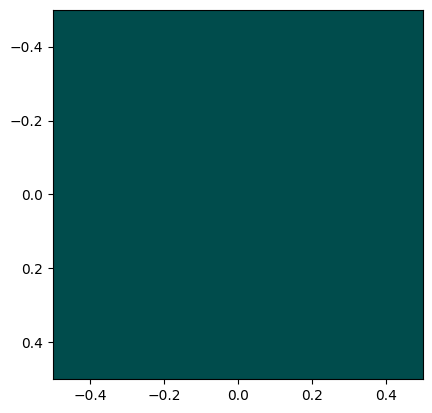

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random pixel values for the image
image_data = np.random.rand(1, 1, 3)  # 100x100 image with 3 color channels (RGB)
image_data[0,0,:] = 0.3
image_data[0,0,0] = 0
# Display the image
plt.imshow(image_data)
plt.show()

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self):
      self.num_images = 3000
      self.images = np.random.rand(self.num_images,1,1,3)

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      return self.images[idx]


In [4]:
training_dataset = CustomImageDataset()

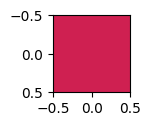

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(1, 1))
plt.imshow(training_dataset[83])
plt.show()

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True, drop_last=True)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomSender(nn.Module):
    def __init__(self):
        super(CustomSender, self).__init__()
        self.num_words = 10
        # Define your layers or modules here
        self.fc1 = nn.Linear(in_features=3, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=self.num_words)


    def forward(self, x):
        x = F.leaky_relu(self.fc1(x.flatten(start_dim=1)))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


class CustomReceiver(nn.Module):
    def __init__(self):
        super(CustomReceiver, self).__init__()
        self.num_words = 10
        self.fc1 = nn.Linear(in_features=3, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=16)
        #
        self.emb = nn.Embedding(self.num_words, 16)
        self.fc3 = nn.Linear(in_features=16, out_features=16)

    def forward_image(self, x):
        x = F.leaky_relu(self.fc1(x.flatten(start_dim=1)))
        x = self.fc2(x)
        return x

    def forward_text(self, x):
        x = F.leaky_relu(self.emb(x))
        x = self.fc3(x)
        return x

In [45]:
m1 = CustomSender()
x = torch.randn(32,1,1,3)
alphs = m1(x).argmax(1)
m2 = CustomReceiver()
m2_img_rprs = m2.forward_image(x)
m2_text_rprs = m2.forward_text(alphs)
alphs

tensor([6, 6, 6, 8, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 8, 6, 6, 6, 6, 8, 6, 6, 6,
        6, 9, 1, 6, 6, 6, 6, 9])

In [46]:
m1_optimizer = torch.optim.Adam(m1.parameters(), lr=1e-3)
m2_optimizer = torch.optim.Adam(m2.parameters(), lr=1e-3)

In [48]:
from torch.distributions import Categorical
import copy

data_iterator = iter(train_dataloader)
acc_list = []
loss_list = []
best_acc = 0
best_model_state = None, None

for iter_num in tqdm(range(10000)):
  try:
    batch = next(data_iterator)
  except StopIteration:
    data_iterator = iter(train_dataloader)
    batch = next(data_iterator)
  m2_optimizer.zero_grad()
  m1_optimizer.zero_grad()
  #####
  message_logits = m1(batch.float())
  message = message_logits.argmax(1)
  m2_img_rprs = m2.forward_image(batch.float())
  m2_mess_rprs = m2.forward_text(message)
  distract_m2_img_rprs = torch.roll(m2_img_rprs, shifts=1, dims=0)
  pos_similarity = F.cosine_similarity(m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  neg_similarity = F.cosine_similarity(distract_m2_img_rprs, m2_mess_rprs).unsqueeze(1)
  similarity_scores = torch.cat([pos_similarity, neg_similarity], axis=1)
  m2_loss = F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]))
  m2_loss.backward()
  m2_optimizer.step()
  ########
  log_probs = torch.log(torch.gather(F.softmax(message_logits, dim=1), 1, message.unsqueeze(1)))
  rewards = -1*F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]), reduction='none').detach()
  returns = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
  m1_loss = -torch.mean(returns * log_probs)
  entropy_loss = -Categorical(F.softmax(message_logits, dim=1)).entropy().sum()
  m1_loss = m1_loss + 0e-3*entropy_loss
  #####
  m1_loss.backward()
  m1_optimizer.step()
  acc = (1 - similarity_scores.argmax(1)).float().mean()
  acc_list.append(acc)
  loss_list.append(m2_loss.item())
  if acc > best_acc:
    print(acc, F.cross_entropy(similarity_scores, torch.LongTensor([0]*similarity_scores.shape[0]), reduction='mean').item())
    best_acc = acc
    best_model_state = copy.deepcopy(m1.state_dict()), copy.deepcopy(m2.state_dict())

  if acc.item() > 0.99:
    print(acc.item())
    break

m1.load_state_dict(best_model_state[0])
m2.load_state_dict(best_model_state[1])


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.4844) 0.6951496005058289
tensor(0.4922) 0.6972362995147705
tensor(0.5234) 0.6914818286895752
tensor(0.5547) 0.6887355446815491
tensor(0.5625) 0.6910086870193481
tensor(0.6172) 0.6857518553733826
tensor(0.6406) 0.6825685501098633
tensor(0.6797) 0.6718802452087402
tensor(0.6875) 0.6638846397399902
tensor(0.7422) 0.6519055962562561
tensor(0.7656) 0.6409027576446533
tensor(0.7734) 0.6203888058662415
tensor(0.7812) 0.6128041744232178
tensor(0.7969) 0.5850470066070557
tensor(0.8047) 0.5535710453987122
tensor(0.8125) 0.5132765769958496
tensor(0.8359) 0.4703551232814789
tensor(0.8672) 0.418471097946167
tensor(0.8750) 0.41468045115470886
tensor(0.8906) 0.3963480293750763
tensor(0.8984) 0.389359712600708
tensor(0.9062) 0.3904215097427368
tensor(0.9297) 0.37792307138442993
tensor(0.9375) 0.38370752334594727
tensor(0.9453) 0.3820687234401703
tensor(0.9531) 0.3849695324897766
tensor(0.9688) 0.3552105724811554
tensor(0.9766) 0.3525925576686859


<All keys matched successfully>

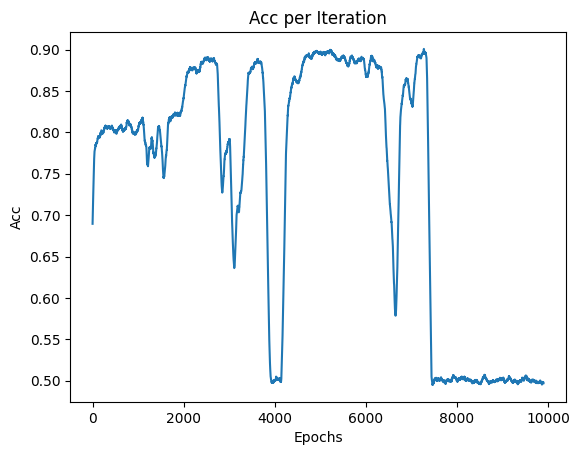

In [49]:
import numpy as np
import matplotlib.pyplot as plt
win_size = 100
smoothed_accuracy = np.convolve(acc_list, np.ones(win_size) / win_size, mode='valid')
plt.plot(smoothed_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Acc per Iteration')
plt.show()

In [50]:
from collections import defaultdict

for batch in train_dataloader:
  message_logits = m1(batch.float())
  message = message_logits.argmax(1)
  
image_dictionary = defaultdict(list)
for i, m in enumerate(message):
  image_dictionary[str(m.item())].append(i)


In [51]:
image_dictionary = dict(sorted(image_dictionary.items(), key=lambda item: item[0]))

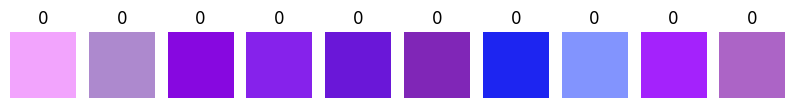

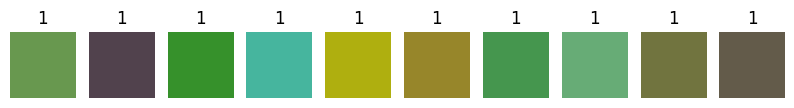

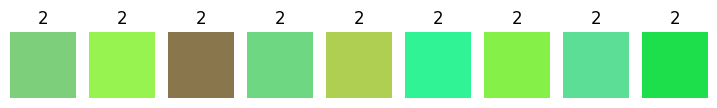

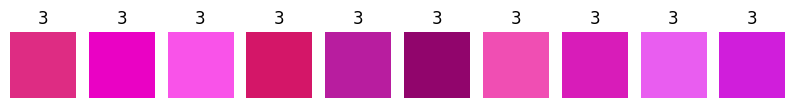

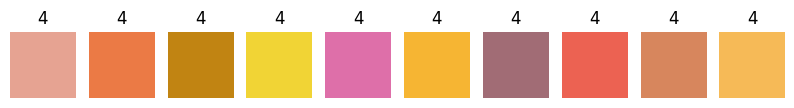

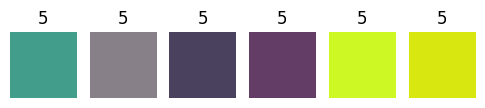

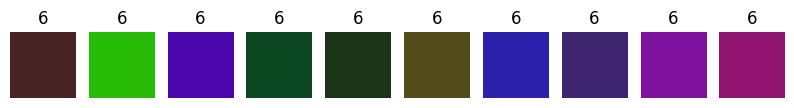

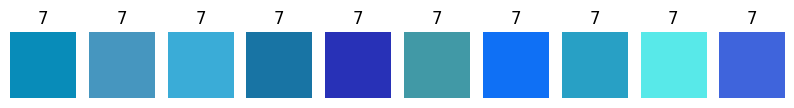

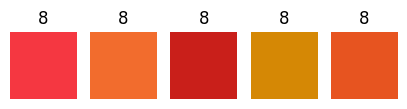

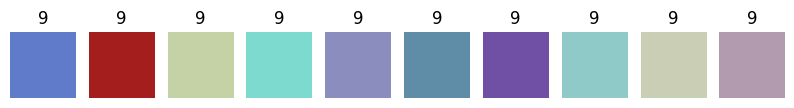

In [52]:
import matplotlib.pyplot as plt

max_image_per_token = 10
for sentence, image_indices in image_dictionary.items():
    image_indices = image_indices[:max_image_per_token]
    num_images = len(image_indices)

    if num_images == 1:
        fig = plt.figure(figsize=(1, 1))
        axs = [plt.subplot(1, 1, 1)]
    else:
        fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    
    for i, image_idx in enumerate(image_indices):
        axs[i].imshow(batch[image_idx])
        axs[i].set_title(f"{sentence}")
        axs[i].axis('off')

    plt.show()
